- **This code is a preparation for computing the CL-DRTO solution using a scenario-based stochastic programming approach and its implementation in the plant.**

The model is the nonlinear version of the bioreactor of Case Study 2 from:*Gao, Ling. "Modeling and dynamics analyses of immobilized CSTR bioreactor using transfer function model." 2012 International Symposium on Information Technologies in Medicine and Education. Vol. 2. IEEE, 2012.*

Here, we code:
- Run a step test with the dynamic model and compare OC model with integrator
- Optimize the dynamic model using an open loop DRTO paradigm (one shot)
- Test MPC's to track setpoints
- Test Closed-loop DRTO

AUTHOR: Jose Matias <assumpcj@mcmaster.ca>
DATE: September 2023

[1.Model: Nonlinear Bioreactor](#sec1) <br>
[2. Integrating dynamic model](#sec3) <br>
[3. Dynamic optimization test](#sec4) <br>
[4. Identifying LMPC models](#sec5) <br>
[5. Testing LMPC for setpoint tracking and disturbance rejection](#sec6) <br>
[6. Testing CL-DRTO](#sec8) <br>

In [1]:
using LinearAlgebra, JuMP, Ipopt, Plots, DifferentialEquations, CSV, DataFrames

<a id="sec1"></a>

# Bioreactor Model

## Main assumptions
- Perfect level control in both reactors
- Perfect Mixing
- Michaelis–Menten kinetics

## Model Equations

$\dfrac{d C}{d t} = D (C_{in} - C) - \dfrac{V_m C}{(K_s + C)} $ <br>
$ \dfrac{d P}{d t} = \dfrac{V_m C}{(K_s + C)} - DP $ <br>

where, <br>
$t$: time in hours \[h\] <br>
$C$: concentration of reactant (substrate) \[g/L\] <br>
$P$: concentration of product (biomass) \[g/L\] <br>
$C_{in}$: inlet concentration of substrate \[g/L\] <br>
$D$: ratio of flowrate to reactor volume \[1/h\] <br>
$V_m$: maximum reaction rate \[g/(h L)\] <br> 
$K_s$: reaction constant \[g/L\] <br>

- System measurement ($y$) - product concentration $P$ <br>
- System inputs ($u$) - inlet reactant concentration $C_{in}$ <br>
- Uncertain parameters ($\theta$) - maximum reaction rate $V_m$

## Model parameter values

In [2]:
# maximum reaction rate (NOTE CHANGE IN PARAMETERS FROM LINEAR)
Vm_nom = 0.75 # [1/h]

# reaction constant (inhibition parameter)
Ks = 0.5 # [g/L]

# Dilution rate ==> D = F/V, Fbar = 2 [L/h], V = 4 [L] 
D = 0.5; # [1/h] 

## Optimization parameters

In [3]:
# number of inputs
nu = 1 #[-]
# number of outputs
ny = 1 #[-]
# number of states
nx = 2 # [-]

# feed concentration limitation  (2.0 vs. 5.0)
Cin_max = 5.0 #[g/L] 

# product setpoint limitation
Psp_max = 1.2 # [g/L]

# Soft upper bounds on P weight
pUB = 1.05 # [g/L]

# objective function weight for P penalization term 
wP = 100

# Objective function: target tracking
pTrack = 1.0; # [g/L]

<a id="sec3"></a>

# Integrating dynamic model

- integration starts from the optimal steady-state point computed above
- compare the results from DAE solver and Orthogonal Collocation in Finite elements

In [4]:
# DRTO prediction horizon
ndrto = 20 + (8 - 1) # p = 8 *controller horizon

# Simulation sampling time
dt = 1 #[h]

# integration (BE) sampling time
n_fe_dt = 5 # number of finite elements/simulation sampling time 

# finite element length
h = dt/n_fe_dt 

# number of finite elements 
nfe = ndrto*n_fe_dt

# INITIAL CONDITION (from paper)
C_0 = 0.358 #[g/L]
P_0 = 0.642 # [g/L]

# States (algebraic and differential): C, P
x0 = [C_0,P_0]

# INPUTS (from paper)
Cin_0 = 1 #[g/L]
u0_step = Cin_0 + 0.1; # step test

## A) using DAE integrator

Preparing integrator

In [5]:
function bioreactor_ode!(dx, x, p, t)
    C,P = x
    Cin = p
    
    # Immobilized enzyme or cell catalytic reaction rate (defined by Michaelis-Menten equation)
    rc = Vm_nom*C/(Ks + C)
    
    # reactor 1
    dx[1] = D*(Cin - C) - rc
    dx[2] = rc - D*P
    
    nothing
end;

Simulating the system

In [6]:
# Simulation time in sampling periods
nsim = ndrto

# time series for plotting
t_integr = Vector{Float64}(undef,nsim) 
for ii in 1:nsim
    t_integr[ii] = dt*ii
end

# time series for plotting
C_integr = Vector{Float64}(undef,nsim) 
P_integr = Vector{Float64}(undef,nsim)

# preparing simulation (inputs are kept constant)
xk = x0

# Simulation time span
tspan = (0.0,dt)

for kk = 1:nsim
    
    ode_prob = ODEProblem(bioreactor_ode!,xk,tspan,u0_step);
    sol =  solve(ode_prob,Tsit5(),reltol=1e-8,abstol=1e-8,save_everystep = false);
    
    # saving data
    C_integr[kk] = sol.u[end][1]
    P_integr[kk] = sol.u[end][2]
    
    # loop
    xk = sol.u[end]
end 

## B) using orthogonal collocation

Preparing orthogonal collocation

In [7]:
# Parameters for orthogonal collocation
#  Radau Collocation Points 1st degree polynomial == Backward Euler
radau  = [0.0 1.00000]

# number of collocation points (initial point is also considered)
ncp = length(radau) 

# Collocation parameters and radau time series
colmat = [-1.0 -1.0;
          1.0 1.0]; 

In [8]:
# JuMP model
m_dyn = Model(Ipopt.Optimizer)
set_optimizer_attribute(m_dyn, "warm_start_init_point", "yes")
set_optimizer_attribute(m_dyn, "print_level", 5)

# Set up variables
@variables(m_dyn, begin
    C[1:nfe, 1:ncp] ≥ 0       # [g/L] substrate concentration (diff states)
    Cdot[1:nfe, 1:ncp]        # [g/L/h] substrate concentration (time derivative)
    P[1:nfe, 1:ncp] ≥ 0       # [g/L] biomass concentration (diff states)
    Pdot[1:nfe, 1:ncp]        # [g/L/h] biomass concentration (time derivative)
    0 ≤ Cin[1:ndrto] ≤ Cin_max  # [g/l] inlet substrate concentration
end)


# Set up initial guesses for solver: using opt. steady-state previoulsy computed
for ii in 1:nfe
    for jj in 1:ncp
        set_start_value(C[ii,jj], C_0)
        set_start_value(P[ii,jj], P_0) 
    end # collocation points loop
end # finite elements loop

for ii in 1:ndrto
    # MV's
    set_start_value(Cin[ii], Cin_0)
end # finite elements loop

# [g/L/h] Immobilized enzyme or cell catalytic reaction rate (defined by Michaelis-Menten equation)
@NLexpression(m_dyn, rc[ii = 1:nfe, jj = 1:ncp], Vm_nom*C[ii,jj]/(Ks + C[ii,jj]))

#Set up the constraints
@NLconstraints(m_dyn, begin
    #########
    # MODEL #
    #########    
    # reactor
    r_C[ii = 1:nfe, jj = 1:ncp], Cdot[ii,jj] == D*(Cin[cld(ii,n_fe_dt)] - C[ii,jj]) - rc[ii,jj] 
    r_P[ii = 1:nfe, jj = 1:ncp], Pdot[ii,jj] == rc[ii,jj] - D*P[ii,jj]
    
    #########################    
    # Collocation Equations #    
    #########################
    # initial point
    coll_C_0, C[1,1] == C_0 
    coll_P_0, P[1,1] == P_0
        
    # set up collocation equations 
    coll_C_n[ii = 1:nfe, jj = 2:ncp], sum(colmat[kk,jj]*C[ii,kk] for kk in 1:ncp) - h*Cdot[ii,jj] == 0 
    coll_P_n[ii = 1:nfe, jj = 2:ncp], sum(colmat[kk,jj]*P[ii,kk] for kk in 1:ncp) - h*Pdot[ii,jj] == 0
        
    # continuinity equations
    coll_C_con[ii = 2:nfe], C[ii,1] - C[ii - 1,ncp] == 0 
    coll_P_con[ii = 2:nfe], P[ii,1] - P[ii - 1,ncp] == 0
        
    ##############    
    # PARAMETERS #
    ##############
    # specifying MV's
    p1[ii = 1:ndrto], Cin[ii] - u0_step == 0
end)

# Set up objective function --> dummy for feasibility problem  
@NLobjective(m_dyn, Min, 0);


In [9]:
# Solve the model
status = optimize!(m_dyn)

# time series for plotting
t_oc = Vector{Float64}(undef,nfe) 
for ii in 1:nfe
    t_oc[ii] = h*ii
end

C_oc = value.(C[:,ncp]) 
P_oc = value.(P[:,ncp]);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2995
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      540

Total number of variables............................:     1107
                     variables with only lower bounds:      540
                variables with lower and upper bounds:       27
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1107
Total number of inequality co

Plotting (substrate, biomass)

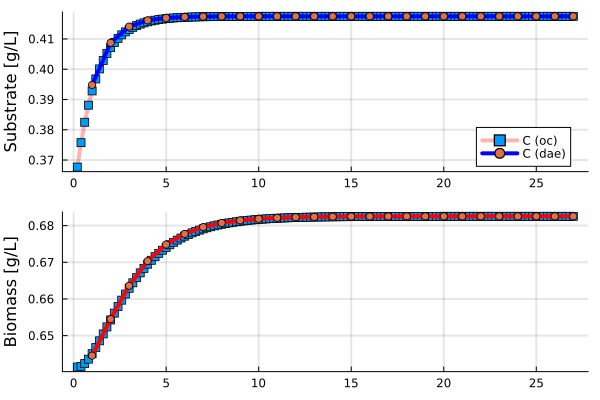

In [10]:
gr()

p1 = plot(t_oc,C_oc,linewidth=4,linecolor = :red,marker=:square,linealpha = 0.3,gridlinewidth=2,yaxis="Substrate [g/L]")
p1 = plot!(t_integr,C_integr,linewidth=4,linecolor = :blue,marker=:circle)

p1.series_list[1][:label] = "C (oc)"
p1.series_list[2][:label] = "C (dae)"

p2 = plot(t_oc,P_oc,linewidth=4,linealpha = 0.3,marker=:square,linecolor = :red,gridlinewidth=2,yaxis="Biomass [g/L]",legend=false)
p2 = plot!(t_integr,P_integr,linewidth=4,linecolor = :red,marker=:circle,legend=false)

g1 = plot(p1,p2,layout=(2,1))
display(g1)


<a id="sec4"></a>

# Optimizing Dynamic Model 

In [11]:
# JuMP model
m_drto = Model(Ipopt.Optimizer)
set_optimizer_attribute(m_drto, "warm_start_init_point", "yes")
set_optimizer_attribute(m_drto, "print_level", 5)

# Set up variables
@variables(m_drto, begin
    C[1:nfe, 1:ncp] ≥ 0.0     # [g/L] substrate concentration (diff states)
    Cdot[1:nfe, 1:ncp]        # [g/L/h] substrate concentration (time derivative)
    P[1:nfe, 1:ncp] ≥ 0.0     # [g/L] biomass concentration (diff states)
    Pdot[1:nfe, 1:ncp]        # [g/L/h] biomass concentration (time derivative)
    0 ≤ Cin[1:ndrto] ≤ Cin_max  # [g/l] inlet substrate concentration
    delta_p[1:nfe] ≥ 0.0      # [g/L] slacks for P soft constraint
end)

# Set up initial guesses for solver: using opt. steady-state previoulsy computed
for ii in 1:nfe
    for jj in 1:ncp
        set_start_value(C[ii,jj], C_0)
        set_start_value(P[ii,jj], P_0) 
    end # collocation points loop
end # finite elements loop

for ii in 1:ndrto
    # MV's
    set_start_value(Cin[ii], Cin_0)
end # finite elements loop

# [g/L/h] Immobilized enzyme or cell catalytic reaction rate (defined by Michaelis-Menten equation)
@NLexpression(m_drto, rc[ii = 1:nfe, jj = 1:ncp], Vm_nom*C[ii,jj]/(Ks + C[ii,jj]))

#Set up the constraints
@NLconstraints(m_drto, begin
    #########
    # MODEL #
    #########    
    # reactor
    r_C[ii = 1:nfe, jj = 1:ncp], Cdot[ii,jj] == D*(Cin[cld(ii,n_fe_dt)] - C[ii,jj]) - rc[ii,jj] 
    r_P[ii = 1:nfe, jj = 1:ncp], Pdot[ii,jj] == rc[ii,jj] - D*P[ii,jj]
    
    #########################    
    # Collocation Equations #    
    #########################
    # initial point
    coll_C_0, C[1,1] == C_0 
    coll_P_0, P[1,1] == P_0
        
    # set up collocation equations 
    coll_C_n[ii = 1:nfe, jj = 2:ncp], sum(colmat[kk,jj]*C[ii,kk] for kk in 1:ncp) - h*Cdot[ii,jj] == 0 
    coll_P_n[ii = 1:nfe, jj = 2:ncp], sum(colmat[kk,jj]*P[ii,kk] for kk in 1:ncp) - h*Pdot[ii,jj] == 0
        
    # continuinity equations
    coll_C_con[ii = 2:nfe], C[ii,1] - C[ii - 1,ncp] == 0 
    coll_P_con[ii = 2:nfe], P[ii,1] - P[ii - 1,ncp] == 0
    
    ###############
    # CONSTRAINTS #
    ###############
    # ! Enforcing only at the end of the finite element
    # P soft constraints
    soft_P[ii = 1:nfe], P[ii] - delta_p[ii] ≤ pUB    
end)

# Set up objective function  
@NLobjective(m_drto, Min, sum((P[ii] - pTrack)^2 + wP*delta_p[ii]^2 for ii in 1:nfe));

In [12]:
# Solve the model
status = optimize!(m_drto)

# time series for plotting
C_traj = value.(C[:,ncp]) 
P_traj = value.(P[:,ncp])
Cin_traj = value.(Cin);

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2968
Number of nonzeros in inequality constraint Jacobian.:      270
Number of nonzeros in Lagrangian Hessian.............:      810

Total number of variables............................:     1242
                     variables with only lower bounds:      675
                variables with lower and upper bounds:       27
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1080
Total number of inequality constraints...............:      135
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      135

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8652137e+01 8.06e-03 2.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

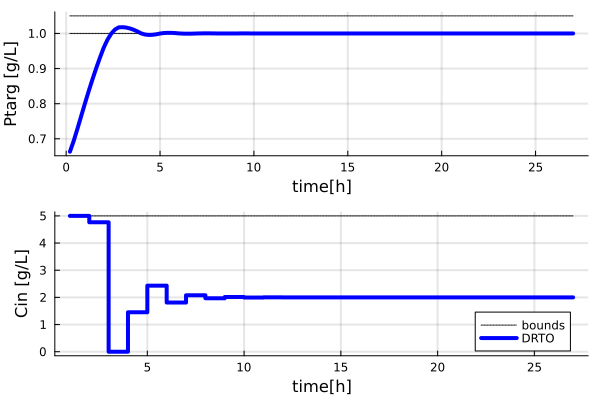

In [13]:
gr()

###########
# OUTPUTS #
###########
# limits
p3 = plot(t_oc,pUB*ones(length(t_oc)),linestyle = :dot,linecolor = :black,xaxis="time[h]",yaxis="Ptarg [g/L]",legend=false,gridlinewidth=2)
p3 = plot!(t_oc,pTrack*ones(length(t_oc)),linestyle = :dot,linecolor = :black,legend=false)
# trajectories
p3 = plot!(t_oc,P_traj,linewidth=4,linecolor = :blue,gridlinewidth=2,legend=false)

###########
# INPUTS #
###########
# limits
p4 = plot(t_integr,Cin_max*ones(length(t_integr)),linestyle = :dot,linecolor = :black,xaxis="time[h]",yaxis="Cin [g/L]",gridlinewidth=2)
# trajectories
p4 = plot!(t_integr,Cin_traj,linetype=:steppost,linewidth=4,linecolor = :blue,gridlinewidth=2)

p4.series_list[1][:label] = "bounds"
p4.series_list[2][:label] = "DRTO"

g2 = plot(p3,p4,layout=(2,1))
display(g2)

<a id="sec5"></a>

# Obtaining MPC models

- The level is assumed to be perfectly controlled (see modeling assumption). No controllers need to be modeled here

In [14]:
# Linearization point
u_lin = 1.0
x_lin = [0.3660;0.6340]
y_lin = 0.6340

# 100 pre-computed models based on parametric uncertainty Vm (computed using matlab: BioReactorLinearization.m)
bioModels = CSV.read("C:\\Users\\MACC-Jose\\Documents\\GitHub\\BD\\Preliminary calculations\\BioreactorModel", DataFrame; header=false)

# extracting the matrices from the model array computed previously
nNom = 50 # nominal model --> index = 50

A = Matrix(bioModels[2*(nNom - 1) + 1:2*(nNom - 1) + 2,1:2]) 
B = bioModels[2*(nNom - 1) + 1:2*(nNom - 1) + 2,3]
C = [0 1];

In [15]:
# computing linearized model response
# time series for plotting
C_lin = Vector{Float64}(undef,nsim)
P_lin = Vector{Float64}(undef,nsim)

# preparing simulation: variables in deviation form
x_lin_k = x0 - x_lin

for kk = 1:nsim
    x_lin_k = A*x_lin_k + B*(u0_step - u_lin)
    
    # saving data
    C_lin[kk] = x_lin_k[1] + x_lin[1]
    P_lin[kk] = x_lin_k[2] + x_lin[2]
end;

## Plotting response vs. linear model

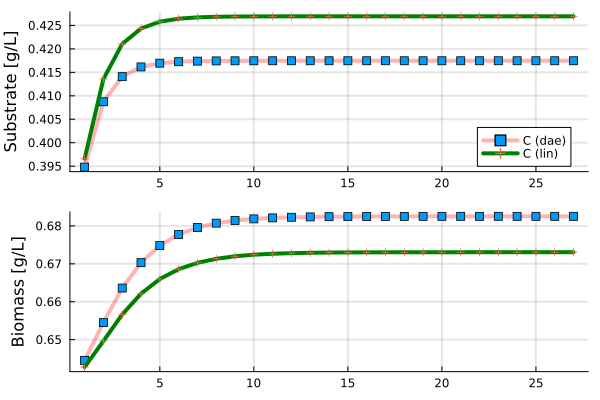

In [16]:
gr()

p5 = plot(t_integr,C_integr,linewidth=4,linecolor = :red,marker=:square,linealpha = 0.3,gridlinewidth=2,yaxis="Substrate [g/L]")
p5 = plot!(t_integr,C_lin,linewidth=4,linecolor = :green,marker=:cross)
p5.series_list[1][:label] = "C (dae)"
p5.series_list[2][:label] = "C (lin)"

p6 = plot(t_integr,P_integr,linewidth=4,linealpha = 0.3,marker=:square,linecolor = :red,gridlinewidth=2,yaxis="Biomass [g/L]",legend=false)
p6 = plot!(t_integr,P_lin,linewidth=4,linecolor = :green,marker=:cross,legend=false)

g3 = plot(p5,p6,layout=(2,1))
display(g3)

<a id="sec6"></a>

# Testing MPC's for setpoint tracking and disturbance rejection

$$ min_{u_k} J_k = \sum_{j=1}^p (y(k + j|k) - y^{SP})^T \ Q \ (y(k + j|k) - y^{SP}) + \sum_{j=1}^{m-1} \Delta u(k + j|k)^T \ R \ \Delta u(k + j|k) $$

$$ s.t.: x(k+1) = A_d \ x(k) + B_d \ u(k) $$
$$ y(k) = C_d \ x(k)$$ 
$$ u_{min} \leq u_k \leq u_{max}  \quad k = 1,\ldots,m $$

where $p$ is the output prediction horizon; $m$ is the input horizon; $y^{sp}$ is the desired value of the output; $Q$ and $R$ are weighting matrices of appropriate di-
mensions.

In [17]:
# prediction horizon 
p = 8

# control horizon 
m = 2

# output tracking weight
q = 1

# move supression weight
r = 1

# input bounds (not in deviation form)
u_mpc_lb = 0.0
u_mpc_ub = Cin_max;

Building MPC matrices based on the plant model and the tuning parameters

**1. Adding disturbance model**

The closed-loop system may never reach the desired controlled variable target if an unmeasured, constant disturbance
enters the process or if model error is present. This problem can be solved by incorporating a constant output disturbance
into the process model: 

$
\begin{vmatrix}
x(k + 1)\\
d(k + 2)
\end{vmatrix}
= 
\begin{vmatrix}
A & 0_{nx,ny}\\
0_{ny,nx} & I_{ny}\\
\end{vmatrix} \ x(k)
\begin{vmatrix}
x(k)\\
d(k)
\end{vmatrix}
+
\begin{vmatrix}
B\\
0_{ny,nu}\end{vmatrix} 
u(k)
$

$
y(k)
= 
\begin{vmatrix}
C & G_p
\end{vmatrix} 
\begin{vmatrix}
x(k)\\
d(k)
\end{vmatrix}
$

in which $d \in \mathcal{R}^{ny}$ is the number of augmented output disturbance states, and $G_p$ determines the effect of these states on the output. In the standard industrial model predictive control implementation, $G_p=I$ and the output
disturbance is estimated as $d_k = y_k - C x_k$.

Abusing notation and refering to the extended state ($[x, d]$) as $x$ and denoting the extended matrices above with the subscript $d$, we have the following discrete state-space model:

$ x(k+1) = A_d \ x(k) + B_d \ u(k) $ <br>
$ y(k) = C_d \ x(k)$ <br>


**2. Building system dynamics matrix for rearranging MPC problem**

Using the supperposition property of linear systems, we obtain the model outputs from instants $k+1$ to $k+j$ as: <br>
$ y(k + 1|k) = C_d \ x(k + 1|k) = C_dA_d \ x(k) + C_dB_d \ u(k|k)$ <br>
$ y(k + 2|k) = C_dA_d^2 \ x(k) + C_dA_dB_d \ u(k|k) + C_dB_d \ u(k+1|k)$ <br>
$ y(k + 3|k) = C_dA_d^3 \ x(k) + C_dA_d^2B_d \ u(k|k) + C_dA_dB_d \ u(k+1|k) + C_dB_d \ u(k+2|k)$ <br>
$ ... $ <br>
$ y(k + j|k) = C_dA_d^j \ x(k) + C_dA_d^{j-1}B_d \ u(k|k) + C_dA_d^{j-2}B_d \ u(k+1|k) + \cdots + C_dB_d \ u(k + j -1|k)$ 

Suppose now that:<br>
$ u(k + m|k) = u(k + m + 1|k) = \cdots = u(k + p - 1|k)$

The equations above (when $j > m$) can then be re-written as:
$ y(k + m + 1|k) = C_dA_d^{m+1} \ x(k) + C_dA_d^{m}B_d \ u(k|k) + C_dA_d^{m-1}B_d \ u(k+1|k) + \cdots + [C_dA_dB_d + C_dB_d] \ u(k + m -1|k)$ <br>
$ y(k + m + 2|k) = C_dA_d^{m+2} \ x(k) + C_dA_d^{m+1}B_d \ u(k|k) + C_dA_d^{m}B_d \ u(k+1|k) + \cdots + [C_dA_d^2B_d + C_dA_dB_d + C_dB_d] \ u(k + m -1|k)$ <br>
$ ... $ <br>
$ y(k + pk) = C_dA_d^{p} \ x(k) + C_dA_d^{p-1}B_d \ u(k|k) + C_dA_d^{p-2}B_d \ u(k+1|k) + \cdots + [C_dA_d^{p-m}B_d + C_dA_d^{p-m-1}B_d + \cdots + C_dB_d] \ u(k + m -1|k)$

Thus, the vector of output predictions can be written as follows:

$
\begin{vmatrix}
y(k + 1|k)\\
y(k + 2|k)\\
\vdots \\
y(k + m|k) \\
y(k + m + 1|k)\\ 
\vdots \\
y(k + p|k)
\end{vmatrix}
= 
\begin{vmatrix}
C_dA_d\\
C_dA_d^{2}\\
\vdots \\
C_dA_d^{m} \\
C_dA_d^{m+1}\\ 
\vdots \\
C_dA_d^{p}
\end{vmatrix} \ x(k)
+
\begin{vmatrix}
C_dB_d          & 0               & \cdots & 0\\
C_dA_dB_d       & C_dB_d          & \cdots & 0\\
\vdots          & \vdots          & \cdots & \vdots\\
C_dA_d^{m-1}B_d & C_dA_d^{m-2}B_d & \cdots & C_dB_d\\
C_dA_d^{m}B_d   & C_dA_d^{m-1}B_d & \cdots & C_d\tilde{A}_{d,1}B_d\\ 
\vdots          & \vdots          & \cdots & \vdots\\
C_dA_d^{p-1}B_d & C_dA_d^{p-2}B_d & \cdots & C_d\tilde{A}_{d,p-m}B_d
\end{vmatrix} 
\begin{vmatrix}
u(k|k)\\
u(k + 2|k)\\
\vdots \\
u(k + m - 1|k) 
\end{vmatrix}
$

where: <br>
$\tilde{A}_{d,1} = A_d + I, \quad \tilde{A}_{d,2} = A_d^2 + A_d + I, \quad \tilde{A}_{d,p-m} = A_d^{p-m} + A_d^{p-m-1} + \cdots + I$

Simpifying, we have: <br>
$ \bar{y}(k) = \Psi \ x(k) + \Theta \ u(k) $ 

**3. Rearranging optimization problem**

The first term (output tracking) of the MPC objective function is: 

$ \sum_{j=1}^p (y(k + j|k) - y^{SP})^T \ Q \ (y(k + j|k) - y^{SP}) $

which can be written as:

$ (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP})^T \ \bar{Q} \ (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP}) $

where: 
$ \bar{Q} = diag\bigg( Q, \cdots, Q\bigg)$ - $p$ repetitions of $Q$

The second term (inputs movement penalization) of the MPC objective function is: 

$ \sum_{j=1}^{m-1} \Delta u(k + j|k)^T \ R \ \Delta u(k + j|k) $

We observe that:
$
\begin{vmatrix}
\Delta u(k|k)\\
\Delta u(k + 1|k)\\
\vdots \\
\Delta u(k + m - 1|k) 
\end{vmatrix}
= 
\begin{vmatrix}
u(k|k) - u(k - 1)\\
u(k + 1|k) - u(k|k)\\
\vdots \\
u(k + m - 1|k) - u(k + m - 2|k)
\end{vmatrix}
=
u_k - Mu_k - \bar{I} u(k - 1)
= (I_{nu,m} - M)u_k - \bar{I} u(k - 1)
= I_M u_k - \bar{I} u(k - 1)
$

in which:
$
M = 
\begin{vmatrix}
0_{nu} & 0_{nu} & \cdots & 0_{nu} & 0_{nu}\\
I_{nu} & 0_{nu} & \cdots & 0_{nu} & 0_{nu}\\
0_{nu} & I_{nu} & \cdots & 0_{nu} & 0_{nu}\\
\vdots & \vdots & \cdots & \vdots & \vdots\\
0_{nu} & 0_{nu} & \cdots & I_{nu} & 0_{nu}
\end{vmatrix}, \quad
\bar{I} = 
\begin{vmatrix}
I_{nu}\\
0_{nu}\\
0_{nu}\\
\vdots\\
0_{nu}
\end{vmatrix}
$

the second term can be written as:

$ (I_M u_k - \bar{I} u(k - 1))^T \ \bar{R} \ (I_M u_k - \bar{I} u(k - 1)) $

where: 
$ \bar{R} = diag\bigg( R, \cdots, R\bigg)$ - $m$ repetitions of $R$

The objective function then can be reduced to a quadratic function of the form:
$$ J_k = u_k^T \ H \ u_k + 2c_f^T \ u_k + c $$

where:

$H = \Theta^T \ \bar{Q} \ \Theta + I_M^T \ \bar{R} \ I_M$ <br>
$c_f^T = (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP})^T \ \bar{Q} \ \Theta + u(k-1)^T\bar{I}^T \ \bar{R} \ I_M$ <br>
$c = (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP})^T \ \bar{Q} \ (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP}) + u(k-1)^T\bar{I}^T \ \bar{R} \ \bar{I} \ u(k-1)$

In [18]:
function MPC_matrices(A,B,C,p,m,q,r)
    ###########
    # inputs: #
    ###########
    # A,B,C - System model
    # p, m - prediction and control horizon
    # q, r - setpoint and input usage tuning parameters
    
    # extracting dimensions from system model
    nx = size(A,1) # states
    nu = size(B,2) # inputs
    ny = size(C,1) # outputs
    
    # adding disturbance model
    Ad = [A zeros(nx,ny); zeros(ny,nx) I(ny)]
    Bd = [B; zeros(ny,nu)]
    Cd = [C ones(ny,ny)]
    
    # building matrices for MPC
    Psi = Cd*Ad
    for ii in 2:p
        Psi = [Psi;  Cd*Ad^ii]
    end

    # Computing Dynamic Matrix
    a = Cd*Bd
    for ii in 2:p
        a = [a; Cd*Ad^(ii - 1)*Bd]
    end
    DynM = a

    for ii in 1:(m - 2)
        a = [zeros(ny,nu);a[1:(p-1)*ny,:]]
        DynM = [DynM  a]
    end

    # adjusting dynamic matrix for since p > m (last column)
    b = Cd*Bd

    Ai = I(nx+1) # adding disturbance to the states
    for ii = 1:(p - m)
        Ai = Ai + Ad^ii
        b = [b;Cd*Ai*Bd]
    end

    Theta=[DynM [zeros(ny*(m-1),nu);b]]
    
    # Creating Qbar and Rbar matrices
    Qbar = Diagonal([q for ii in 1:p])
    Rbar = Diagonal([r for ii in 1:m])

    # Creating input movement OF penalty matrix 
    M=[zeros((m-1)*nu,nu) I(nu*(m-1)); zeros(nu) zeros(nu,nu*(m-1))]
    Ibar=[I(nu); zeros(nu*(m-1),nu)]
    IM = I(nu*m) - M';
    
    # Matrix H
    H = Theta'*Qbar*Theta + IM'*Rbar*IM;
    
    return Dict('A' => A, 'B' => B, 'C' => C, 'H' => H, 'Θ' => Theta, 'Ψ' => Psi, 'Q' => Qbar, 'I' => Ibar, 'R' => Rbar, 'M' => IM)
end;

Creating function that solves MPC problem

- After rearranging the system, the MPC matrices become:

$$ min_{u_k} J_k = u_k^T \ H \ u_k + 2c_f^T \ u_k + c $$

$$ s.t.: u_{min} \leq u_k \leq u_{max}  \quad k = 1,\ldots,m $$ 

In [19]:
function solveMPC(xkk,dekk,uk_1,yspk,umin,umax,yref,uref,mpc,p,m)
    ###########
    # inputs: #
    ###########
    # xkk - current states (MPC model) 
    # dekk - disturbance estimate 
    # uk_1 - inputs at the current iteration, already implemented on the plant
    # yspk - setpoint trajectory computed by CL-DRTO
    # umin, umax - input bounds
    # yref, uref - reference points for computing deviation variables
    # mpcModel - System model
    # p, m - prediction and control horizon
    
    MPC_con = Model(Ipopt.Optimizer)
    set_silent(MPC_con)
    
    ####################
    # Set up variables #
    ####################
    # inputs computed by MPCs
    @variable(MPC_con, (umin - uref) ≤ u[1:m] ≤ (umax - uref) )
    
    ######################################
    # Set up constraints and expressions #
    ######################################
    # for OF computation
    @expression(MPC_con, cfT, (mpc['Ψ']*[xkk;dekk] - (yspk - yref)*ones(p,1))'*mpc['Q']*mpc['Θ'] - (uk_1 - uref)'*mpc['I']'*mpc['R']*mpc['M'])
        
    #############################
    # Set up objective function #
    #############################
    @objective(MPC_con, Min, sum(u[jj]*sum(mpc['H'][jj,ii]*u[ii] for ii in 1:m) for jj in 1:m) + 2*sum(cfT[jj]*u[jj] for jj = 1:m))
    # @show MPC_con

    #################
    # Solve Problem #
    #################
    optimize!(MPC_con)

    #calling values of the solved problem
    ϕ = objective_value(MPC_con)
    uArray = value.(u) .+ uref

    return Dict('ϕ' => ϕ,'u' => uArray)
end;

## Simulation for testing MPC performance

In [20]:
# MPC test simulation length
nmpc = 60

# Integration step 
tspan = (0.0,dt)

# time series for plotting
t_mpc = Vector{Float64}(undef,nmpc) 
for kk in 1:nmpc
    t_mpc[kk] = dt*kk
end

# Control Setpoint
P_sp = Vector{Float64}(undef,nmpc) 
for kk in 1:nmpc
    if kk < nmpc/2  
        P_sp[kk] = pTrack
    else
        P_sp[kk] = pTrack - 0.05
    end
end

# time series for plotting
P_mpc = Vector{Float64}(undef,nmpc)
Cin_mpc = Vector{Float64}(undef,nmpc)

# building MPC: P <-> Cin
mpc = MPC_matrices(A,B,C,p,m,q,r)

# preparing simulation 
xk = x0
uk = Cin_0

# mpc's models - initial states is the same
xk_mpc = x0 - x_lin
dek_mpc = 0.0

for kk = 1:nmpc
    display("MPC test: Iteration $(kk)")

    # solving MPC

    sol_mpc = solveMPC(xk_mpc,dek_mpc,uk,P_sp[kk],u_mpc_lb,u_mpc_ub,x_lin[2],u_lin,mpc,p,m)
    
    # evolving plant
    ode_prob = ODEProblem(bioreactor_ode!,xk,tspan,sol_mpc['u'][1]);
    sol =  solve(ode_prob,Tsit5(),reltol=1e-8,abstol=1e-8,save_everystep = false);

    # evolving MPC models
    xk_mpc  = A*xk_mpc + B*(sol_mpc['u'][1] - u_lin)
    dek_mpc = sol.u[end][2] - (xk_mpc[2] + x_lin[2])

    # saving data
    P_mpc[kk] = sol.u[end][2]
    Cin_mpc[kk]= sol_mpc['u'][1]
    
    # loop
    xk = sol.u[end]
    uk = sol_mpc['u'][1]
    
end 

"MPC test: Iteration 1"

"MPC test: Iteration 2"

"MPC test: Iteration 3"

"MPC test: Iteration 4"

"MPC test: Iteration 5"

"MPC test: Iteration 6"

"MPC test: Iteration 7"

"MPC test: Iteration 8"

"MPC test: Iteration 9"

"MPC test: Iteration 10"

"MPC test: Iteration 11"

"MPC test: Iteration 12"

"MPC test: Iteration 13"

"MPC test: Iteration 14"

"MPC test: Iteration 15"

"MPC test: Iteration 16"

"MPC test: Iteration 17"

"MPC test: Iteration 18"

"MPC test: Iteration 19"

"MPC test: Iteration 20"

"MPC test: Iteration 21"

"MPC test: Iteration 22"

"MPC test: Iteration 23"

"MPC test: Iteration 24"

"MPC test: Iteration 25"

"MPC test: Iteration 26"

"MPC test: Iteration 27"

"MPC test: Iteration 28"

"MPC test: Iteration 29"

"MPC test: Iteration 30"

"MPC test: Iteration 31"

"MPC test: Iteration 32"

"MPC test: Iteration 33"

"MPC test: Iteration 34"

"MPC test: Iteration 35"

"MPC test: Iteration 36"

"MPC test: Iteration 37"

"MPC test: Iteration 38"

"MPC test: Iteration 39"

"MPC test: Iteration 40"

"MPC test: Iteration 41"

"MPC test: Iteration 42"

"MPC test: Iteration 43"

"MPC test: Iteration 44"

"MPC test: Iteration 45"

"MPC test: Iteration 46"

"MPC test: Iteration 47"

"MPC test: Iteration 48"

"MPC test: Iteration 49"

"MPC test: Iteration 50"

"MPC test: Iteration 51"

"MPC test: Iteration 52"

"MPC test: Iteration 53"

"MPC test: Iteration 54"

"MPC test: Iteration 55"

"MPC test: Iteration 56"

"MPC test: Iteration 57"

"MPC test: Iteration 58"

"MPC test: Iteration 59"

"MPC test: Iteration 60"

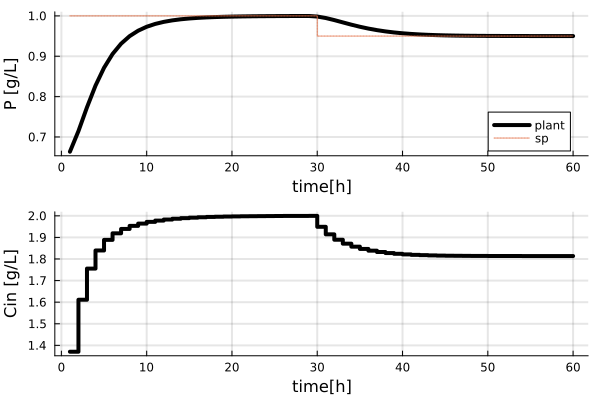

In [21]:
gr()

###########
# OUTPUTS #
###########
p7 = plot(t_mpc,P_mpc,linewidth=4,linecolor=:black,gridlinewidth=2,yaxis="P [g/L]",xaxis="time[h]")
p7 = plot!(t_mpc,P_sp,linestyle=:dot,linetype=:steppost)
p7.series_list[1][:label] = "plant"
p7.series_list[2][:label] = "sp"

###########
# INPUTS #
###########
p8 = plot(t_mpc,Cin_mpc,linetype=:steppost,linewidth=4,linecolor = :black,gridlinewidth=2,yaxis="Cin [g/L]",xaxis="time[h]",legend=false)
#p8 = plot(t_mpc,Cin_max*ones(length(t_mpc)),linestyle = :dot)

g4 = plot(p7,p8,layout=(2,1))
display(g4)

<a id="sec8"></a>

# Testing deterministic CL-DRTO (one shot)

In [22]:
# Optimization control horizon 
mD = 20 

# time series for plotting
t_cldrto_nf = Vector{Float64}(undef,nfe) 
for kk in 1:nfe
    t_cldrto_nf[kk] = h*kk
end

t_cldrto = Vector{Float64}(undef,ndrto) 
for kk in 1:ndrto
    t_cldrto[kk] = dt*kk
end

# building MPC's: P <-> Cin
mpc = MPC_matrices(A,B,C,p,m,q,r)

# setting bounds (all arbitrary - not in deviation form!!) 
uMax = 5.0 # for tight constraints: 1.9 | for loose constraints: 5.0
uMin = 0.0

yspMax = 1.2 
yspMin = 0.0
    
yref = y_lin
uref = u_lin

# initial value of u
u0 = Cin_0;

# initial value of xMPC
xMPC_0 = x0 - x_lin
de_0 = 0;

- Diagram illustrating the prediction/control horizon inside DRTO and how the setpoint sequence is sent to the controller

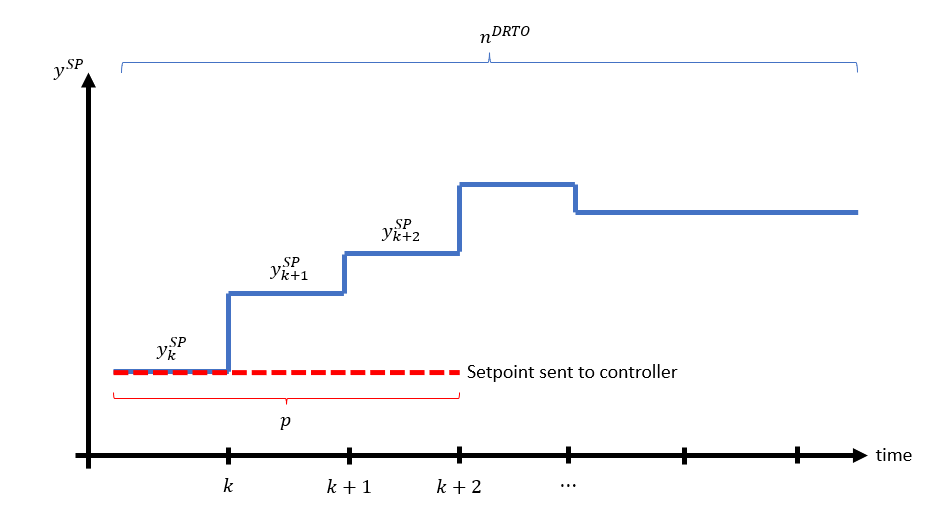

## Testing with unconstrained MPC

The FOC of the unconstrained MPC problem is:

$$ \dfrac{\partial J_k}{\partial u_k}\bigg|_{u_k^\star} = 2 \ u_k^{\star,T} \ H + 2c_f^T = 0 $$ 
 
Hence: 

$$ \ u_k^{\star,T} \ H + c_f^T = 0 $$ 
$$ \ u_k^{\star,T} \ H = - c_f^T $$ 

Transposing both sides ($H$ is symmetric, $H^T = H$):

$$ H \ u_k^{\star} = - c_f $$ 

In [23]:
# JuMP model
m_cldrto_uc = Model(Ipopt.Optimizer)
set_optimizer_attribute(m_cldrto_uc, "warm_start_init_point", "yes")
set_optimizer_attribute(m_cldrto_uc, "print_level", 5)

####################
# Set up variables #
####################
# DRTO model variables
@variable(m_cldrto_uc, C[1:nfe, 1:ncp] ≥ 0.0)    # [g/L] substrate concentration (diff states)
@variable(m_cldrto_uc, P[1:nfe, 1:ncp] ≥ 0.0)    # [g/L] biomass concentration (diff states)
@variable(m_cldrto_uc, Cdot[1:nfe, 1:ncp])       # [g/L/h] substrate concentration (time derivative)
@variable(m_cldrto_uc, Pdot[1:nfe, 1:ncp])       # [g/L/h] biomass concentration (time derivative)
@variable(m_cldrto_uc, delta_p[1:nfe] ≥ 0.0)     # [g/L] soft constraint on P
@variable(m_cldrto_uc, 0.0 ≤ Cin[1:ndrto] ≤ Cin_max) # [g/L] substrate feed to reactor

# MPC model variables (SISO) -> deviation form
@variable(m_cldrto_uc, xMPC[1:nx,1:ndrto])
@variable(m_cldrto_uc, uMPC[1:ndrto,1:m]) 
@variable(m_cldrto_uc, uMPC_w_c[1:mD,1:m]) # inputs w/o clipping
    
# input clipping 
@variable(m_cldrto_uc, mu_lb[1:mD,1:m] ≥ 0)
@variable(m_cldrto_uc, eta_lb[1:mD,1:m] ≥ 0)
@variable(m_cldrto_uc, mu_ub[1:mD,1:m] ≥ 0)
@variable(m_cldrto_uc, eta_ub[1:mD,1:m] ≥ 0)       

# MPC <-> DRTO model deviation
@variable(m_cldrto_uc, de[1:(ndrto - 1)])
    
# setpoints for the controllers sent to the plant (*CL-DRTO degrees of freedom)
@variable(m_cldrto_uc, yspMin ≤ ysp[1:ndrto] ≤ yspMax)

# Set up initial guesses for solver: using opt. steady-state previoulsy computed
for kk in 1:ndrto
    for jj in 1:ncp
        set_start_value(C[kk,jj], C_0) 
        set_start_value(P[kk,jj], P_0)
    end # collocation points loop
end # finite elements loop

for kk in 1:ndrto
    # MV's
    set_start_value(Cin[kk], Cin_0)
    
    for mm in 1:m
        set_start_value(uMPC[kk,mm], Cin_0 - uref)
    end
end # finite elements loop

##############
# DRTO model #
##############
# [g/L/h] Immobilized enzyme or cell catalytic reaction rate (defined by Michaelis-Menten equation)
@NLexpression(m_cldrto_uc, rc[kk = 1:nfe, jj = 1:ncp], Vm_nom*C[kk,jj]/(Ks + C[kk,jj]))

#Set up the constraints
@NLconstraints(m_cldrto_uc, begin
    #########
    # MODEL #
    #########    
    # reactor
    r_C[kk = 1:nfe, jj = 1:ncp], Cdot[kk,jj] == D*(Cin[cld(kk,n_fe_dt)] - C[kk,jj]) - rc[kk,jj] 
    r_P[kk = 1:nfe, jj = 1:ncp], Pdot[kk,jj] == rc[kk,jj] - D*P[kk,jj]
    #########################    
    # Collocation Equations #    
    #########################
    # initial point
    coll_C_0, C[1,1] == C_0 
    coll_P_0, P[1,1] == P_0  
    # set up collocation equations 
    coll_C_n[kk = 1:nfe, jj = 2:ncp], sum(colmat[ii,jj]*C[kk,ii] for ii in 1:ncp) - h*Cdot[kk,jj] == 0 
    coll_P_n[kk = 1:nfe, jj = 2:ncp], sum(colmat[ii,jj]*P[kk,ii] for ii in 1:ncp) - h*Pdot[kk,jj] == 0    
    # continuinity equations
    coll_C_con[kk = 2:nfe], C[kk,1] - C[kk - 1,ncp] == 0 
    coll_P_con[kk = 2:nfe], P[kk,1] - P[kk - 1,ncp] == 0 
end)

##########################
# MPC model and solution #
##########################
# N.B. inside MPC everything is in deviation variables
@expressions(m_cldrto_uc, begin
    cfT_1, (mpc['Ψ']*[xMPC_0;de_0] - (ysp[1:p] .- yref))'*mpc['Q']*mpc['Θ'] - (u0 - uref)*mpc['I']'*mpc['R']*mpc['M']
    cfT[kk = 1:(mD - 1)], (mpc['Ψ']*[xMPC[:,kk];de[kk]] - (ysp[(kk + 1):(kk + 1 + p - 1)] .- yref))'*mpc['Q']*mpc['Θ'] - uMPC_w_c[kk,1]*mpc['I']'*mpc['R']*mpc['M']
end)

@constraints(m_cldrto_uc, begin
    #############
    # MPC model #
    #############
    MPC_dyn_model_1, xMPC[:,1] .== mpc['A']*xMPC_0 + mpc['B']*(u0 - uref)
    MPC_dyn_model[kk = 1:mD], xMPC[:,kk + 1] .== mpc['A']*xMPC[:,kk] + mpc['B']*uMPC_w_c[kk,1]
    MPC_dyn_model_mD[kk = (mD + 1):(ndrto - 1)], xMPC[:,kk + 1] .== mpc['A']*xMPC[:,kk] + mpc['B']*uMPC[kk,1]
    MPC_model_dev[kk = 1:(ndrto - 1)], de[kk] == (P[kk,ncp] - yref) - xMPC[2,kk]
    ################
    # MPC solution #
    ################
    #MPC_sol_1, mpc['H']*uMPC_w_c[1,:] + cfT_1' .== 0
    #MPC_sol[kk = 1:(mD - 1)], mpc['H']*uMPC_w_c[kk + 1,:] + cfT[kk]' .== 0
    MPC_sol_1[uu = 1:m], sum(mpc['H'][uu,ii]*uMPC_w_c[1,ii] for ii in 1:m) + cfT_1[uu] == 0.0    
    MPC_sol[kk=1:(mD - 1),uu = 1:m], sum(mpc['H'][uu,ii]*uMPC_w_c[kk + 1,ii] for ii in 1:m) + cfT[kk][uu] == 0.0    
    ##################
    # input clipping #
    ##################
    ic_1[kk = 1:mD,uu = 1:m], uMPC[kk,uu] == uMPC_w_c[kk,uu] - mu_ub[kk,uu] + mu_lb[kk,uu]
    ic_2[kk = 1:mD,uu = 1:m], (uMax - uref) - uMPC[kk,uu] == eta_ub[kk,uu]
    ic_3[kk = 1:mD,uu = 1:m], eta_ub[kk,uu]*mu_ub[kk,uu] ≤ 1e-6
    ic_4[kk = 1:mD,uu = 1:m], uMPC[kk,uu] - (uMin - uref) == eta_lb[kk,uu]
    ic_5[kk = 1:mD,uu = 1:m], eta_lb[kk,uu]*mu_lb[kk,uu] ≤ 1e-6
end)

@constraints(m_cldrto_uc, begin   
    ###############
    # CONSTRAINTS #
    ###############
    # ! Enforcing only at the end of the finite element
    # P soft constraints
    soft_P[kk = 1:nfe], P[kk] - delta_p[kk] ≤ pUB
    # fixing setpoint changes after mD
    control_horizon[kk = (mD+1):ndrto,uu = 1:m], uMPC[kk,uu] == uMPC[mD,uu]
    ############################
    # OPTIMIZATION CONSTRAINTS #
    ############################
    # connecting the MPC solution to the DRTO model (only the first element of the MV* is implemented)
    hc[kk = 1:ndrto], (uMPC[kk,1] + uref) - Cin[kk] == 0
end)

# Set up objective function  
@NLobjective(m_cldrto_uc, Min, sum((P[kk] - pTrack)^2 + wP*delta_p[kk]^2 for kk in 1:nfe));

In [24]:
# @show model_ms
optimize!(m_cldrto_uc)
flag = termination_status(m_cldrto_uc)
# primal_status(m_cldrto_uc)
    
#calling values of the solved problem
yspArray_uc = value.(ysp)

# time series for plotting
C_cldro_uc = value.(C[:,ncp])
P_cldrto_uc = value.(P[:,ncp])
Cin_cldrto_uc = value.(Cin);

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     4145
Number of nonzeros in inequality constraint Jacobian.:      430
Number of nonzeros in Lagrangian Hessian.............:      890

Total number of variables............................:     1603
                     variables with only lower bounds:      835
                variables with lower and upper bounds:       54
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1361
Total number of inequality constraints...............:      215
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      215

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1066123e+02 3.99e+00 2.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

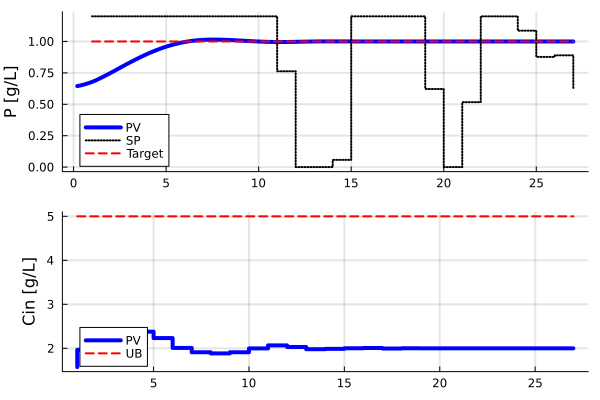

In [25]:
gr() 

p9 = plot(t_cldrto_nf,P_cldrto_uc,linewidth=4,linecolor = :blue,gridlinewidth=2,yaxis="P [g/L]")
p9 = plot!(t_cldrto,yspArray_uc,linewidth=2,linetype=:steppost,linestyle = :dot, linecolor = :black)
p9 = plot!(t_cldrto,pTrack*ones(length(t_cldrto)),linewidth=2,linestyle = :dash, linecolor = :red)
p9.series_list[1][:label] = "PV"
p9.series_list[2][:label] = "SP"
p9.series_list[3][:label] = "Target"

p10 = plot(t_cldrto,Cin_cldrto_uc,linetype=:steppre,linewidth=4,linecolor = :blue,gridlinewidth=2,yaxis="Cin [g/L]")
p10 = plot!(t_cldrto,Cin_max*ones(length(t_cldrto)),linewidth=2,linestyle = :dash, linecolor = :red)
p10.series_list[1][:label] = "PV"
p10.series_list[2][:label] = "UB"

g5 = plot(p9,p10,layout=(2,1))
display(g5)

## Testing with constrained MPC

Since we are considering constraints, the optimization problem reads as:

$$ min_{u_k} J_k = u_k^T \ H \ u_k + 2c_f^T \ u_k + c $$

$$ s.t.: u_{min} \leq u_k \leq u_{max}  \quad k = 1,\ldots,m $$ 
 
considering m = 3, we can rewrite the constraints as:

$ u_k - u_{max} \leq 0 \quad k = 1,2,3  $ <br>
$ u_{min} - u_k \leq 0 \quad k = 1,2,3  $ <br>

**Solving the problem via KKT**

The Lagrangian of the problem above is: 
$$ L = u_k^T \ H \ u_k + 2c_f^T \ u_k + c + 
\begin{vmatrix}
\mu_{UB,1} \ \mu_{UB,2} \ \mu_{UB,3} \ \mu_{LB,1} \ \mu_{LB,2} \ \mu_{LB,3}
\end{vmatrix} 
\begin{vmatrix}
u_{max} - u_1\\ u_{max} - u_2 \\ u_{max} - u_3 \\ u_1 - u_{min} \\ u_2 - u_{min}\\ u_3 - u_{min}
\end{vmatrix}
$$

The KKT conditions can be written as

- Stationarity of the Lagrangian <br>
$ \nabla_u L = 
\begin{vmatrix}
u_{1} & u_{2} & u_{3}
\end{vmatrix} 
\ H + c_f^T +  
\begin{vmatrix}
\mu_{UB,1} & \mu_{UB,2} & \mu_{UB,3} & \mu_{LB,1} & \mu_{LB,2} & \mu_{LB,3}
\end{vmatrix} 
\begin{vmatrix}
-1 & 0 & 0 \\ 0 & -1 & 0 \\ 0 & 0 & -1 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1
\end{vmatrix}
$ <br>

- Primal Feasibility <br>
$
\begin{vmatrix}
u_{max} - u_1\\ u_{max} - u_2 \\ u_{max} - u_3 \\ u_1 - u_{min} \\ u_2 - u_{min}\\ u_3 - u_{min}
\end{vmatrix}
\geq 0
$ <br>

- Dual Feasibility <br>
$
\begin{vmatrix}
\mu_{UB,1} \\ \mu_{UB,2} \\ \mu_{UB,3} \\ \mu_{LB,1} \\ \mu_{LB,2} \\ \mu_{LB,3}
\end{vmatrix}
\geq 0
$ <br>

- Complementarity Slackness <br>
$
\begin{vmatrix}
\mu_{UB,1} & \mu_{UB,2} & \mu_{UB,3} & \mu_{LB,1} & \mu_{LB,2} & \mu_{LB,3}
\end{vmatrix}
\begin{vmatrix}
u_1 - u_{max} \\ u_2 - u_{max} \\ u_3 - u_{max} \\ u_{min} - u_1 \\ u_{min} - u_2 \\ u_{min} - u_3
\end{vmatrix}
= 0
$ <br>

**Strategy: $\ell_1$ penalization**

Here, the complemetarity can be moved from the constraints to the objective function (of the CLDRTO problem), and the resulting problem is solved for a particular value of $\pi$. If $\pi \geq \pi_c$, where $\rho_c$ is the critical value of the penalty parameter, then the complementarity constraints will be satisfied at the solution.

e.g.: 
$$\min \ \phi_{CLDRTO}(w) + \pi \ \boldsymbol{\mu}^T \boldsymbol{u}$$

In [26]:
# Parameters
# matrix to compute the gradients of the input bound constraints
conMatrix = [-I(m); I(m)];

In [27]:
# JuMP model
m_cldrto_c = Model(Ipopt.Optimizer)
set_optimizer_attribute(m_cldrto_c, "warm_start_init_point", "yes")
set_optimizer_attribute(m_cldrto_c, "print_level", 5)

####################
# Set up variables #
####################
# DRTO model variables
@variable(m_cldrto_c, C[1:nfe, 1:ncp] ≥ 0.0)    # [g/L] substrate concentration (diff states)
@variable(m_cldrto_c, P[1:nfe, 1:ncp] ≥ 0.0)    # [g/L] biomass concentration (diff states)
@variable(m_cldrto_c, Cdot[1:nfe, 1:ncp])       # [g/L/h] substrate concentration (time derivative)
@variable(m_cldrto_c, Pdot[1:nfe, 1:ncp])       # [g/L/h] biomass concentration (time derivative)
@variable(m_cldrto_c, delta_p[1:nfe] ≥ 0.0)     # [g/L] soft constraint on P
@variable(m_cldrto_c, 0.0 ≤ Cin[1:ndrto] ≤ Cin_max) # [g/L] substrate feed to reactor

# MPC model variables (SISO) -> deviation form
@variable(m_cldrto_c, xMPC[1:nx,1:ndrto])
@variable(m_cldrto_c, uMPC[1:ndrto,1:m]) 

# MPC <-> DRTO model deviation
@variable(m_cldrto_c, de[1:(ndrto - 1)])

# Constrained MPC KKT conditions (upper and lower bounds for each input)
@variable(m_cldrto_c, mu_g[1:mD,1:(2*m)] ≥ 0, start = 0) 
    
# setpoints for the controllers sent to the plant (*CL-DRTO degrees of freedom)
@variable(m_cldrto_c, yspMin ≤ ysp[1:ndrto] ≤ yspMax)

# Set up initial guesses for solver: using opt. steady-state previoulsy computed
for kk in 1:nfe
    for jj in 1:ncp
        set_start_value(C[kk,jj], C_0) 
        set_start_value(P[kk,jj], P_0)
    end # collocation points loop
end # finite elements loop

for kk in 1:ndrto
    # MV's
    set_start_value(Cin[kk], Cin_0)
    
    for mm in 1:m
        set_start_value(uMPC[kk,mm], Cin_0 - uref)
    end
end 

##############
# DRTO model #
##############
# [g/L/h] Immobilized enzyme or cell catalytic reaction rate (defined by Michaelis-Menten equation)
@NLexpression(m_cldrto_c, rc[kk = 1:nfe, jj = 1:ncp], Vm_nom*C[kk,jj]/(Ks + C[kk,jj]))

#Set up the constraints
@NLconstraints(m_cldrto_c, begin
    #########
    # MODEL #
    #########    
    # reactor
    r_C[kk = 1:nfe, jj = 1:ncp], Cdot[kk,jj] == D*(Cin[cld(kk,n_fe_dt)] - C[kk,jj]) - rc[kk,jj] 
    r_P[kk = 1:nfe, jj = 1:ncp], Pdot[kk,jj] == rc[kk,jj] - D*P[kk,jj]
    #########################    
    # Collocation Equations #    
    #########################
    # initial point
    coll_C_0, C[1,1] == C_0 
    coll_P_0, P[1,1] == P_0  
    # set up collocation equations 
    coll_C_n[kk = 1:nfe, jj = 2:ncp], sum(colmat[ii,jj]*C[kk,ii] for ii in 1:ncp) - h*Cdot[kk,jj] == 0 
    coll_P_n[kk = 1:nfe, jj = 2:ncp], sum(colmat[ii,jj]*P[kk,ii] for ii in 1:ncp) - h*Pdot[kk,jj] == 0
    # continuinity equations
    coll_C_con[kk = 2:nfe], C[kk,1] - C[kk - 1,ncp] == 0 
    coll_P_con[kk = 2:nfe], P[kk,1] - P[kk - 1,ncp] == 0 
end)


##########################
# MPC model and solution #
##########################
# N.B. inside MPC everything is in deviation variables
@expressions(m_cldrto_c, begin
    cfT_1, (mpc['Ψ']*[xMPC_0;de_0] - (ysp[1:p] .- yref))'*mpc['Q']*mpc['Θ'] - (u0 - uref)*mpc['I']'*mpc['R']*mpc['M']
    cfT[kk = 1:(mD - 1)], (mpc['Ψ']*[xMPC[:,kk];de[kk]] - (ysp[(kk + 1):(kk + 1 + p - 1)] .- yref))'*mpc['Q']*mpc['Θ'] - uMPC[kk,1]*mpc['I']'*mpc['R']*mpc['M']
    # Input bounds
    MPC_u_upper[kk = 1:mD,uu = 1:m], (uMax - uref) - uMPC[kk,uu]
    MPC_u_lower[kk = 1:mD,uu = 1:m], uMPC[kk,uu] - (uMin - uref)
end)

@constraints(m_cldrto_c, begin
    #############
    # MPC model #
    #############
    MPC_dyn_model_1, xMPC[:,1] .== mpc['A']*xMPC_0 + mpc['B']*(u0 - uref)
    MPC_dyn_model[kk = 1:(ndrto - 1)], xMPC[:,kk + 1] .== mpc['A']*xMPC[:,kk] + mpc['B']*uMPC[kk,1]
    MPC_model_dev[kk = 1:(ndrto - 1)], de[kk] == (P[kk,ncp] - yref) - xMPC[2,kk]
    ################
    # MPC solution #
    ################
    # stationarity
    MPC_sol_sta_1, uMPC[1,:]'*mpc['H'] + cfT_1 +  mu_g[1,:]'*conMatrix .== 0
    MPC_sol_sta[kk = 1:(mD - 1)], uMPC[kk + 1,:]'*mpc['H'] + cfT[kk] +  mu_g[kk + 1,:]'*conMatrix .== 0
    # primal feasibility
    MPC_sol_feas_ub[kk = 1:mD,uu = 1:m], MPC_u_upper[kk,uu] ≥ 0
    MPC_sol_feas_lb[kk = 1:mD,uu = 1:m], MPC_u_lower[kk,uu] ≥ 0
end)

@constraints(m_cldrto_c, begin   
    ###############
    # CONSTRAINTS #
    ###############
    # ! Enforcing only at the end of the finite element
    # P soft constraints
    soft_P[kk = 1:nfe], P[kk] - delta_p[kk] ≤ pUB
    # fixing setpoint changes after mD
    control_horizon[kk = (mD+1):ndrto,uu = 1:m], uMPC[kk,uu] == uMPC[mD,uu]
    ############################
    # OPTIMIZATION CONSTRAINTS #
    ############################
    # connecting the MPC solution to the DRTO model (only the first element of the MV* is implemented)
    hc[kk = 1:ndrto], (uMPC[kk,1] + uref) - Cin[kk] == 0.0
end);

## Testing strategy with objective function penalty for solving constrained MPC problem

In [28]:
# trial weights for complementarity relaxation OF term
pi_w_Array = [0.1 10 10^2 10^3 10^5 10^6] 

nTest = length(pi_w_Array)

comp_gap = Vector{Float64}(undef,nTest) 

for ii = 1:nTest
    println("Const. >> Iteration: ",ii)
    # solving problem with relaxed complementarity slackness
    # Modifying OF of the original problem  
    @NLobjective(m_cldrto_c, Min, sum((P[kk] - pTrack)^2 + wP*delta_p[kk]^2 for kk in 1:nfe)
    + pi_w_Array[ii]*sum(
                  sum(mu_g[kk,uu]*MPC_u_upper[kk,uu] for uu = 1:m) +
                  sum(mu_g[kk,m + uu]*MPC_u_lower[kk,uu] for uu = 1:m)
                for kk = 1:mD)
        )
        
    # solving problem
    optimize!(m_cldrto_c)

    #calling values of the solved problem
    mu_sol = value.(mu_g)
    mpc_u_sol = value.(MPC_u_upper)
    mpc_l_sol = value.(MPC_u_lower)
    
    # checking the complementarity gap
    comp_gap[ii] = abs(sum(
                  sum(mu_sol[kk,uu]*mpc_u_sol[kk,uu] for uu = 1:m) +
                  sum(mu_sol[kk,m + uu]*mpc_l_sol[kk,uu] for uu = 1:m)
                for kk = 1:mD))
    
end

Const. >> Iteration: 1
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3905
Number of nonzeros in inequality constraint Jacobian.:      350
Number of nonzeros in Lagrangian Hessian.............:     1010

Total number of variables............................:     1483
                     variables with only lower bounds:      755
                variables with lower and upper bounds:       54
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1241
Total number of inequality constraints...............:      215
        inequality constraints with only lower bounds:       80
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      135

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8852137e+01 1.07e+00 2.00e+00  -1.0 0.00e+00   

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3905
Number of nonzeros in inequality constraint Jacobian.:      350
Number of nonzeros in Lagrangian Hessian.............:     1010

Total number of variables............................:     1483
                     variables with only lower bounds:      755
                variables with lower and upper bounds:       54
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1241
Total number of inequality constraints...............:      215
        inequality constraints with only lower bounds:       80
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      135

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1865194e+02 1.07e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3905
Number of nonzeros in inequality constraint Jacobian.:      350
Number of nonzeros in Lagrangian Hessian.............:     1010

Total number of variables............................:     1483
                     variables with only lower bounds:      755
                variables with lower and upper bounds:       54
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1241
Total number of inequality constraints...............:      215
        inequality constraints with only lower bounds:       80
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      135

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0001845e+05 1.07e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

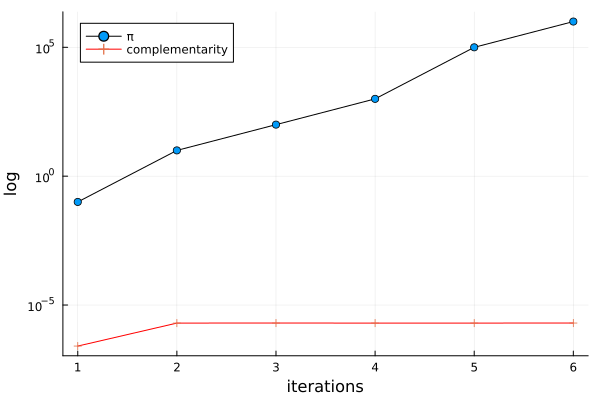

In [29]:
gr()

p11 = plot(1:nTest,pi_w_Array', yaxis="log",xaxis="iterations",linecolor = :black,marker= :circle,
            xticks = 1:nTest,legend=:topleft,yscale=:log10)
p11 = plot!(1:nTest,comp_gap, linecolor = :red,marker= :cross,xticks = 1:nTest,yscale=:log10,legend=:topleft)
p11.series_list[1][:label] = "π"
p11.series_list[2][:label] = "complementarity"

display(p11)

## Comparing the solution profiles of strategies 1 and 2

In [30]:
# Using pi = 1e3 (form iteration 3)  
@NLobjective(m_cldrto_c, Min, sum((P[kk] - pTrack)^2 + wP*delta_p[kk]^2 for kk in 1:nfe)
    + 1e3*sum(
                  sum(mu_g[kk,uu]*MPC_u_upper[kk,uu] for uu = 1:m) +
                  sum(mu_g[kk,m + uu]*MPC_u_lower[kk,uu] for uu = 1:m)
                for kk = 1:mD)
        )
        
# solving problem
optimize!(m_cldrto_c)

#calling values of the solved problem
yspArray_c = value.(ysp)

# time series for plotting
C_cldro_c = value.(C[:,ncp])
P_cldrto_c = value.(P[:,ncp])
Cin_cldrto_c = value.(Cin);

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3905
Number of nonzeros in inequality constraint Jacobian.:      350
Number of nonzeros in Lagrangian Hessian.............:     1010

Total number of variables............................:     1483
                     variables with only lower bounds:      755
                variables with lower and upper bounds:       54
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1241
Total number of inequality constraints...............:      215
        inequality constraints with only lower bounds:       80
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      135

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0186501e+03 1.07e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

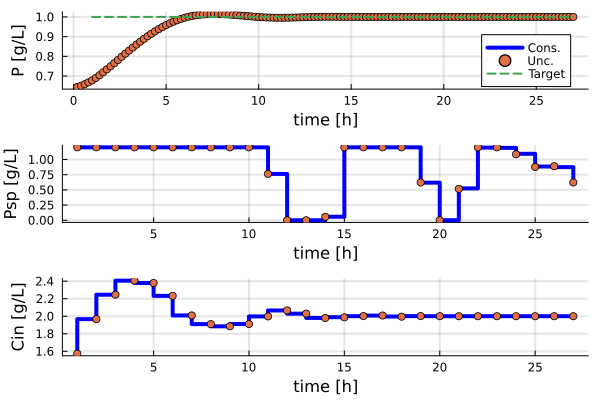

In [31]:
gr() 

p12 = plot(t_cldrto_nf,P_cldrto_c,linewidth=4,linecolor = :blue,gridlinewidth=2,xaxis="time [h]",yaxis="P [g/L]")
p12 = scatter!(t_cldrto_nf,P_cldrto_uc)
p12 = plot!(t_cldrto,pTrack*ones(length(t_cldrto)),linewidth=2,linestyle = :dash)
p12.series_list[1][:label] = "Cons."
p12.series_list[2][:label] = "Unc."
p12.series_list[3][:label] = "Target"

p13 = plot(t_cldrto,yspArray_c,linetype=:steppost,linewidth=4,linecolor = :blue,gridlinewidth=2,xaxis="time [h]",yaxis="Psp [g/L]",legend=false)
p13 = scatter!(t_cldrto,yspArray_uc,legend=false)

p14 = plot(t_cldrto,Cin_cldrto_c,linetype=:steppre,linewidth=4,linecolor = :blue,gridlinewidth=2,xaxis="time [h]",yaxis="Cin [g/L]",legend=false)
p14 = scatter!(t_cldrto,Cin_cldrto_uc,legend=false)

g6 = plot(p12,p13,p14,layout=(3,1))
display(g6)